<a href="https://colab.research.google.com/github/fnoritomi/projeto_sih/blob/main/sih_dengue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Regressão Linear com a base reduzida do SIH

## Instalação da biblioteca PySUS

[https://github.com/AlertaDengue/PySUS](https://github.com/AlertaDengue/PySUS)

In [1]:
!sudo apt install libffi-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libffi-dev
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 63.7 kB of archives.
After this operation, 336 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libffi-dev amd64 3.4.2-4 [63.7 kB]
Fetched 63.7 kB in 0s (324 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package libffi-dev:amd64.
(Reading database ... 124926 files and directori

In [2]:
!sudo pip install PySUS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.6/462.6 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.7/385.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.7/118.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━

## Carregamento das bibliotecas e configurações do Notebook

In [3]:
from pysus.online_data.SIM import download as download_sim
from pysus.online_data.CNES import download as download_cnes
import pandas as pd
import duckdb
from zipfile import ZipFile
import ftplib
import pandas as pd
from io import BytesIO
import os
import requests
import json
import ssl
import math
import glob
import os
import shutil
from google.colab import files
from google.colab import drive

# Monta o Google Drive no Workspace do Notebook
drive.mount('/content/drive')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_info_columns', 200)

duckdb.sql('INSTALL httpfs')
duckdb.sql('LOAD httpfs')
duckdb.sql('INSTALL spatial')
duckdb.sql('LOAD spatial')

Mounted at /content/drive


In [4]:
from pysus.ftp.databases.sih import SIH


In [6]:
sih = SIH().load() # Carrega lista de arquivos do DATASUS
files = sih.get_files("RD", uf="DF", year=[2022, 2023, 2024])
sih_files = sih.download(files)

RDDF2411.parquet: 100%|██████████| 69.3k/69.3k [00:05<00:00, 13.0kB/s]


In [13]:
destino = '/content/drive/MyDrive/Colab Notebooks/Dados/sih'

for arquivo in sih_files:
  shutil.move(str(arquivo), destino)

In [27]:
def sql_query(query):
  return duckdb.sql(query).df()

In [106]:
sql_query(f"""
  select FINANC, count(1) from dengue_df
  group by all
  order by 1
""")

,FINANC,count(1)
0,04,7
1,06,10881


In [147]:
query = f"""
  SELECT ANO_CMPT::USMALLINT as ano,
    MES_CMPT::UTINYINT as mes,
    ESPEC as cd_especialidade,
    -- CGC_HOSP,
    --N_AIH,
    --IDENT,
    --CEP,
    MUNIC_RES as cd_municipio_res,
    --NASC,
    SEXO as cd_sexo,
    --UTI_MES_IN, UTI_MES_AN, UTI_MES_AL,
    UTI_MES_TO::UTINYINT as qt_diarias_uti,
    MARCA_UTI as cd_tipo_uti,
    --UTI_INT_IN, UTI_INT_AN, UTI_INT_AL,
    UTI_INT_TO::UTINYINT as qt_diarias_uti_interm,
    DIAR_ACOM::UTINYINT as qt_diarias_acompanhante,
    QT_DIARIAS::UTINYINT as qt_diarias,
    PROC_SOLIC as cd_proc_solicitado,
    PROC_REA as cd_proc_realizado,
    VAL_SH::DECIMAL(15, 2) as vl_sh,
    VAL_SP::DECIMAL(15, 2) as vl_sp,
    --VAL_SADT, VAL_RN, VAL_ACOMP, VAL_ORTP, VAL_SANGUE, VAL_SADTSR, VAL_TRANSP, VAL_OBSANG, VAL_PED1AC,
    VAL_TOT::DECIMAL(15, 2) as vl_total,
    VAL_UTI::DECIMAL(15, 2) as vl_uti,
    --US_TOT,
    --DT_INTER,
    --DT_SAIDA,
    DIAG_PRINC as cd_diag_princ,
    DIAG_SECUN as cd_diag_sec,
    COBRANCA as cd_motivo_alta_perm,
    --NATUREZA,
    NAT_JUR as cd_natureza_juridica,
    --GESTAO,
    --RUBRICA,
    --IND_VDRL,
    MUNIC_MOV as cd_municipio_estab,
    COD_IDADE as cd_unidade_idade,
    IDADE as idade,
    DIAS_PERM::UTINYINT as qt_dias_permanencia,
    MORTE as cd_morte,
    NACIONAL as cd_nacionalidade,
    --NUM_PROC,
    CAR_INT as cd_carater_atendimento,
    --TOT_PT_SP,
    --CPF_AUT,
    --HOMONIMO,
    --NUM_FILHOS,
    --INSTRU,
    --CID_NOTIF,
    --CONTRACEP1,
    --CONTRACEP2,
    --GESTRISCO,
    --INSC_PN,
    --SEQ_AIH5,
    --CBOR, CNAER, VINCPREV,
    --GESTOR_COD, GESTOR_TP, GESTOR_CPF, GESTOR_DT,
    CNES cd_cnes,
    --CNPJ_MANT, INFEHOSP,
    --CID_ASSO,
    --CID_MORTE,
    COMPLEX AS cd_complexidade,
    FINANC AS cd_tipo_financiamento,
    --FAEC_TP, REGCT,
    RACA_COR cd_raca_cor,
    --ETNIA,
    --SEQUENCIA, REMESSA, AUD_JUST, SIS_JUST,
    --VAL_SH_FED, VAL_SP_FED, VAL_SH_GES, VAL_SP_GES,
    --VAL_UCI, MARCA_UCI,
    --DIAGSEC1, DIAGSEC2, DIAGSEC3, DIAGSEC4, DIAGSEC5, DIAGSEC6, DIAGSEC7, DIAGSEC8, DIAGSEC9,
    --TPDISEC1, TPDISEC2, TPDISEC3, TPDISEC4, TPDISEC5, TPDISEC6, TPDISEC7, TPDISEC8, TPDISEC9
  FROM parquet_scan('/content/drive/MyDrive/Colab Notebooks/Dados/sih/*/*.parquet')
  WHERE TRIM(DIAG_PRINC) IN ('A90', 'A91')
  """
dengue_df = sql_query(query)

In [148]:
dengue_df.head()

,ano,mes,cd_especialidade,cd_municipio_res,cd_sexo,qt_diarias_uti,cd_tipo_uti,qt_diarias_uti_interm,qt_diarias_acompanhante,qt_diarias,cd_proc_solicitado,cd_proc_realizado,vl_sh,vl_sp,vl_total,vl_uti,cd_diag_princ,cd_diag_sec,cd_motivo_alta_perm,cd_natureza_juridica,cd_municipio_estab,cd_unidade_idade,idade,qt_dias_permanencia,cd_morte,cd_nacionalidade,cd_carater_atendimento,cd_cnes,cd_complexidade,cd_tipo_financiamento,cd_raca_cor
0,2022,1,03,530010,3,0,00,0,0,1,0303010010,0303010010,229.44,58.32,287.76,0.0,A90,0000,12,1023,530010,4,22,1,0,010,02,2672197,02,06,03
1,2022,1,03,530010,3,0,00,0,3,3,0303010010,0303010010,362.20,69.98,432.18,0.0,A90,0000,15,1023,530010,4,22,3,0,010,02,0010502,02,06,03
2,2022,1,07,530010,3,0,00,0,8,8,0303010010,0303010010,436.51,79.27,515.78,0.0,A90,0000,12,1023,530010,4,4,8,0,010,02,0010502,02,06,03
3,2022,1,03,530010,3,0,00,0,2,2,0303010010,0303010010,294.52,69.98,364.50,0.0,A90,0000,12,1023,530010,4,27,2,0,010,02,0010502,02,06,01
4,2022,1,03,530010,3,0,00,0,3,3,0303010010,0303010010,291.39,58.32,349.71,0.0,A90,0000,12,1023,530010,4,62,3,0,010,02,2645157,02,06,99


In [149]:
dengue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10888 entries, 0 to 10887
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ano                      10888 non-null  uint16 
 1   mes                      10888 non-null  uint8  
 2   cd_especialidade         10888 non-null  object 
 3   cd_municipio_res         10888 non-null  object 
 4   cd_sexo                  10888 non-null  object 
 5   qt_diarias_uti           10888 non-null  uint8  
 6   cd_tipo_uti              10888 non-null  object 
 7   qt_diarias_uti_interm    10888 non-null  uint8  
 8   qt_diarias_acompanhante  10888 non-null  uint8  
 9   qt_diarias               10888 non-null  uint8  
 10  cd_proc_solicitado       10888 non-null  object 
 11  cd_proc_realizado        10888 non-null  object 
 12  vl_sh                    10888 non-null  float64
 13  vl_sp                    10888 non-null  float64
 14  vl_total              

In [153]:
especialidades = {
  '01': 'Cirurgia',
  '02': 'Obstetrícia',
  '03': 'Clínica médica',
  '04': 'Crônicos',
  '05': 'Psiquiatria',
  '06': 'Pneumologia sanitária',
  '07': 'Pediatria',
  '08': 'Reabilitação',
  '09': 'Hospital dia (cirúrgicos)',
  '10': 'Hospital dia (AIDS)',
  '11': 'Hospital dia (fibrose cística)',
  '12': 'Hospital dia (intercorrência pós transplantes)',
  '13': 'Hospital dia (geriatria)',
  '14': 'Hospital dia (saúde mental)'
}

dengue_df['especialidade']=dengue_df.cd_especialidade.replace(especialidades)
dengue_df.especialidade.value_counts()

,count
especialidade,
Clínica médica,6150
Pediatria,4732
Cirurgia,6


In [154]:
sexos = {
  '1': 'Masculino',
  '2': 'Feminino',
  '3': 'Feminino',
  '0': 'NA',
  '9': 'NA'
}
dengue_df['sexo']=dengue_df.cd_sexo.replace(sexos)
dengue_df.sexo.value_counts()

,count
sexo,
Feminino,5754
Masculino,5134


In [155]:
tipos_utis = {
  '00': 'Não utilizou UTI',
  '74': 'UTI adulto - tipo I',
  '75': 'UTI adulto - tipo II',
  '76': 'UTI adulto - tipo III',
  '77': 'UTI infantil - tipo I',
  '78': 'UTI infantil - tipo II',
  '79': 'UTI infantil - tipo III',
  '80': 'UTI neonatal - tipo I',
  '81': 'UTI neonatal - tipo II',
  '82': 'UTI neonatal - tipo III',
  '83': 'UTI de queimados',
  '85': 'UTI coronariana tipo II - UCO tipo II',
  '86': 'UTI coronariana tipo III - UCO tipo III',
  '99': 'UTI Doador',
  '01': 'Utilizou mais de um tipo de UTI'
}

dengue_df['tipo_uti']=dengue_df.cd_tipo_uti.replace(tipos_utis)
dengue_df.tipo_uti.value_counts()

,count
tipo_uti,
Não utilizou UTI,10197
UTI adulto - tipo II,521
UTI infantil - tipo II,144
UTI infantil - tipo III,12
UTI neonatal - tipo II,7
UTI adulto - tipo III,5
UTI neonatal - tipo III,1
Utilizou mais de um tipo de UTI,1


In [156]:
motivos_alta_perm = {
  '11': 'Alta curado',
  '12': 'Alta melhorado',
  '14': 'Alta a pedido',
  '15': 'Alta com previsão de retorno p/acomp do paciente',
  '16': 'Alta por evasão',
  '18': 'Alta por outros motivos',
  '19': 'Alta de paciente agudo em psiquiatria',
  '21': 'Permanência por características próprias da doença',
  '22': 'Permanência por intercorrência',
  '23': 'Permanência por impossibilidade sócio-familiar',
  '24': 'Permanência proc doação órg, tec, cél-doador vivo',
  '25': 'Permanência proc doação órg, tec, cél-doador morto',
  '26': 'Permanência por mudança de procedimento',
  '27': 'Permanência por reoperação',
  '28': 'Permanência por outros motivos',
  '29': 'Transferência para internação domiciliar',
  '32': 'Transferência para internação domiciliar',
  '31': 'Transferência para outro estabelecimento',
  '41': 'Óbito com DO fornecida pelo médico assistente',
  '42': 'Óbito com DO fornecida pelo IML',
  '43': 'Óbito com DO fornecida pelo SVO',
  '51': 'Encerramento administrativo',
  '61': 'Alta da mãe/puérpera e do recém-nascido',
  '17': 'Alta da mãe/puérpera e do recém-nascido',
  '62': 'Alta da mãe/puérpera e permanência recém-nascido',
  '13': 'Alta da mãe/puérpera e permanência recém-nascido',
  '63': 'Alta da mãe/puérpera e óbito do recém-nascido',
  '64': 'Alta da mãe/puérpera com óbito fetal',
  '65': 'Óbito da gestante e do concepto',
  '66': 'Óbito da mãe/puérpera e alta do recém-nascido',
  '67': 'Óbito da mãe/puérpera e permanência recém-nascido'
}

dengue_df['motivo_alta_perm']=dengue_df.cd_motivo_alta_perm.replace(motivos_alta_perm)
dengue_df.motivo_alta_perm.value_counts()

,count
motivo_alta_perm,
Alta melhorado,7844
Alta com previsão de retorno p/acomp do paciente,1473
Transferência para outro estabelecimento,643
Alta por evasão,235
Alta por outros motivos,234
Óbito com DO fornecida pelo médico assistente,137
Permanência por mudança de procedimento,86
Alta curado,70
Permanência por intercorrência,45


In [157]:
naturezas_juridicas = {
  '1015':"Órgão Público do Poder Executivo Federal",
  '1023':"Órgão Público do Poder Exec Estadual ou Distr Fed",
  '1031':"Órgão Público do Poder Executivo Municipal",
  '1040':"Órgão Público do Poder Legislativo Federal",
  '1058':"Órgão Público do Poder Legisl Estadual ou Dist Fed",
  '1066':"Órgão Público do Poder Legislativo Municipal",
  '1074':"Órgão Público do Poder Judiciário Federal",
  '1082':"Órgão Público do Poder Judiciário Estadual",
  '1104':"Autarquia Federal",
  '1112':"Autarquia Estadual ou do Distrito Federal",
  '1120':"Autarquia Municipal",
  '1139':"Fundação Federal",
  '1147':"Fundação Estadual ou do Distrito Federal",
  '1155':"Fundação Municipal",
  '1163':"Órgão Público Autônomo Federal",
  '1171':"Órgão Público Autônomo Estadual ou Distr Federal",
  '1180':"Órgão Público Autônomo Estadual ou Distr Federal",
  '1198':"Comissão Polinacional",
  '1201':"Fundo Público",
  '1210':"Associação Pública",
  '2011':"Empresa Pública",
  '2038':"Sociedade de Economia Mista",
  '2046':"Sociedade Anônima Aberta",
  '2054':"Sociedade Anônima Fechada",
  '2062':"Sociedade Empresária Limitada",
  '2070':"Sociedade Empresária em Nome Coletivo",
  '2089':"Sociedade Empresária em Comandita Simples",
  '2097':"Sociedade Empresária em Comandita por Ações",
  '2127':"Sociedade em Conta de Participação",
  '2135':"Empresário (Individual)",
  '2143':"Cooperativa",
  '2151':"Consórcio de Sociedades",
  '2160':"Grupo de Sociedades",
  '2178':"Estabelecimento no Brasil de Sociedade Estrangeira",
  '2194':"Estab no Brasil Empr Binacional Argentina-Brasil",
  '2216':"Empresa Domiciliada no Exterior",
  '2224':"Clube/Fundo de Investimento",
  '2232':"Sociedade Simples Pura",
  '2240':"Sociedade Simples Limitada",
  '2259':"Sociedade Simples em Nome Coletivo",
  '2267':"Sociedade Simples em Comandita Simples",
  '2275':"Empresa Binacional",
  '2283':"Consórcio de Empregadores",
  '2291':"Consórcio Simples",
  '2305':"Empr Individ Responsab Limitada (Natur Empresária)",
  '2313':"Empr Individ Responsab Limitada (Natureza Simples)",
  '3034':"Serviço Notarial e Registral (Cartório)",
  '3069':"Fundação Privada",
  '3077':"Serviço Social Autônomo",
  '3085':"Condomínio Edilício",
  '3107':"Comissão de Conciliação Prévia",
  '3115':"Entidade de Mediação e Arbitragem",
  '3123':"Partido Político",
  '3131':"Entidade Sindical",
  '3204':"Estab no Brasil de Fundação ou Associação Estrang",
  '3212':"Fundação ou Associação Domiciliada no Exterior",
  '3220':"Organização Religiosa",
  '3239':"Comunidade Indígena",
  '3247':"Fundo Privado",
  '3999':"Associação Privada",
  '4014':"Empresa Individual Imobiliária",
  '4022':"Segurado Especial",
  '4081':"Contribuinte Individual",
  '4090':"Candidato a Cargo Político Eletivo",
  '4111':"Leiloeiro",
  '5010':"Organização Internacional",
  '5029':"Representação Diplomática Estrangeira",
  '5037':"Outras Instituições Extraterritoriais",
  '0000':""
}

dengue_df['natureza_juridica']=dengue_df.cd_natureza_juridica.replace(naturezas_juridicas)
dengue_df.natureza_juridica.value_counts()

,count
natureza_juridica,
Órgão Público do Poder Exec Estadual ou Distr Fed,7192
Serviço Social Autônomo,3086
Fundação Federal,278
Sociedade Empresária Limitada,157
Sociedade Anônima Fechada,92
Associação Privada,81
Fundação Privada,2


In [158]:
unidades_idade = {
  "2": "Dias",
  "3": "Meses",
  "4": "Anos",
  "5": "Anos a partir de 100",
  "0": ""
}
dengue_df['unidade_idade']=dengue_df.cd_unidade_idade.replace(unidades_idade)
dengue_df.unidade_idade.value_counts()

,count
unidade_idade,
Anos,10325
Meses,509
Dias,51
Anos a partir de 100,3


In [159]:
def calcula_idade_anos(cd_unidade_idade, idade):
  if cd_unidade_idade == '2':
    return float(idade)/365
  elif cd_unidade_idade == '3':
    return float(idade)/12
  elif cd_unidade_idade == '4':
    return float(idade)
  elif cd_unidade_idade == '5':
    return 100 + float(idade)

dengue_df['idade_anos']=dengue_df[['cd_unidade_idade', 'idade']].apply(lambda x: calcula_idade_anos(x.cd_unidade_idade, x.idade), axis=1)

In [160]:
dengue_df.idade_anos.describe()

,idade_anos
count,10888.000000
mean,29.993357
std,25.617480
min,0.010959
25%,8.000000
50%,23.000000
75%,51.000000
max,105.000000


In [162]:
morte = {
  '00': 0,
  '01': 1
}
dengue_df['lg_morte']=dengue_df.cd_morte.replace(morte)
dengue_df.lg_morte.value_counts()


,count
lg_morte,
0,10723
1,165


In [164]:
dengue_df['lg_brasileiro']=dengue_df.cd_nacionalidade.apply(lambda x: 1 if x == '010' else 0)
dengue_df.lg_brasileiro.value_counts()

,count
lg_brasileiro,
1,10862
0,26


In [165]:
carateres_atedimento = {
  '01': 'Eletivo',
  '02': 'Urgência',
  '03': 'Acidente no local trabalho ou a serv da empresa',
  '04': 'Acidente no trajeto para o trabalho',
  '05': 'Outros tipo de acidente de trânsito',
  '06': 'Outros tipos de lesões'
}
dengue_df['carater_atendimento']=dengue_df.cd_carater_atendimento.replace(carateres_atedimento)
dengue_df.carater_atendimento.value_counts()

,count
carater_atendimento,
Urgência,10737
Eletivo,151


In [166]:
complexidades = {
  '01': 'Atenção básica',
  '02': 'Média complexidade',
  '03': 'Alta complexidade'
}
dengue_df['complexidade']=dengue_df.cd_complexidade.replace(complexidades)
dengue_df.complexidade.value_counts()

,count
complexidade,
Média complexidade,10880
Alta complexidade,8


In [167]:
tipos_financiamento = {
  '01': 'Atenção Básica (PAB)',
  '02': 'Assistência Farmacêutica',
  '04': 'Fundo de Ações Estratégicas (FAEC)',
  '05': 'Incentivo - MAC',
  '06': 'Média e Alta Complexidade (MAC)',
  '07': 'Vigilância em Saúde',
  '00': 'NA',
  '09': 'NA'
}
dengue_df['tipo_financiamento']=dengue_df.cd_tipo_financiamento.replace(tipos_financiamento)
dengue_df.tipo_financiamento.value_counts()

,count
tipo_financiamento,
Média e Alta Complexidade (MAC),10881
Fundo de Ações Estratégicas (FAEC),7


In [168]:
racas_cores = {
  '01': 'Branca',
  '02': 'Preta',
  '03': 'Parda',
  '04': 'Amarela',
  '05': 'Indígena',
  '00': 'NA',
  '99': 'NA'
}
dengue_df['raca_cor']=dengue_df.cd_raca_cor.replace(racas_cores)
dengue_df.raca_cor.value_counts()

,count
raca_cor,
Parda,7601
Branca,2235
NA,586
Preta,389
Amarela,77


In [173]:
colunas_reorganizadas = [
    'ano',
    'mes',
    'cd_especialidade',
    'especialidade',
    'cd_municipio_res',
    'cd_sexo',
    'sexo',
    'qt_diarias_uti',
    'cd_tipo_uti',
    'tipo_uti',
    'qt_diarias_uti_interm',
    'qt_diarias_acompanhante',
    'qt_diarias',
    'cd_proc_solicitado',
    'cd_proc_realizado',
    'vl_sh',
    'vl_sp',
    'vl_total',
    'vl_uti',
    'cd_diag_princ',
    'cd_diag_sec',
    'cd_motivo_alta_perm',
    'motivo_alta_perm',
    'cd_natureza_juridica',
    'natureza_juridica',
    'cd_municipio_estab',
    'cd_unidade_idade',
    'unidade_idade',
    'idade',
    'idade_anos',
    'qt_dias_permanencia',
    'cd_morte',
    'lg_morte',
    'cd_nacionalidade',
    'lg_brasileiro',
    'cd_carater_atendimento',
    'carater_atendimento',
    'cd_cnes',
    'cd_complexidade',
    'complexidade',
    'cd_tipo_financiamento',
    'tipo_financiamento',
    'cd_raca_cor',
    'raca_cor'
]
dengue_df = dengue_df[colunas_reorganizadas]

In [174]:
dengue_df.head()

,ano,mes,cd_especialidade,especialidade,cd_municipio_res,cd_sexo,sexo,qt_diarias_uti,cd_tipo_uti,tipo_uti,qt_diarias_uti_interm,qt_diarias_acompanhante,qt_diarias,cd_proc_solicitado,cd_proc_realizado,vl_sh,vl_sp,vl_total,vl_uti,cd_diag_princ,cd_diag_sec,cd_motivo_alta_perm,motivo_alta_perm,cd_natureza_juridica,natureza_juridica,cd_municipio_estab,cd_unidade_idade,unidade_idade,idade,idade_anos,qt_dias_permanencia,cd_morte,lg_morte,cd_nacionalidade,lg_brasileiro,cd_carater_atendimento,carater_atendimento,cd_cnes,cd_complexidade,complexidade,cd_tipo_financiamento,tipo_financiamento,cd_raca_cor,raca_cor
0,2022,1,03,Clínica médica,530010,3,Feminino,0,00,Não utilizou UTI,0,0,1,0303010010,0303010010,229.44,58.32,287.76,0.0,A90,0000,12,Alta melhorado,1023,Órgão Público do Poder Exec Estadual ou Distr Fed,530010,4,Anos,22,22.0,1,0,0,010,1,02,Urgência,2672197,02,Média complexidade,06,Média e Alta Complexidade (MAC),03,Parda
1,2022,1,03,Clínica médica,530010,3,Feminino,0,00,Não utilizou UTI,0,3,3,0303010010,0303010010,362.20,69.98,432.18,0.0,A90,0000,15,Alta com previsão de retorno p/acomp do paciente,1023,Órgão Público do Poder Exec Estadual ou Distr Fed,530010,4,Anos,22,22.0,3,0,0,010,1,02,Urgência,0010502,02,Média complexidade,06,Média e Alta Complexidade (MAC),03,Parda
2,2022,1,07,Pediatria,530010,3,Feminino,0,00,Não utilizou UTI,0,8,8,0303010010,0303010010,436.51,79.27,515.78,0.0,A90,0000,12,Alta melhorado,1023,Órgão Público do Poder Exec Estadual ou Distr Fed,530010,4,Anos,4,4.0,8,0,0,010,1,02,Urgência,0010502,02,Média complexidade,06,Média e Alta Complexidade (MAC),03,Parda
3,2022,1,03,Clínica médica,530010,3,Feminino,0,00,Não utilizou UTI,0,2,2,0303010010,0303010010,294.52,69.98,364.50,0.0,A90,0000,12,Alta melhorado,1023,Órgão Público do Poder Exec Estadual ou Distr Fed,530010,4,Anos,27,27.0,2,0,0,010,1,02,Urgência,0010502,02,Média complexidade,06,Média e Alta Complexidade (MAC),01,Branca
4,2022,1,03,Clínica médica,530010,3,Feminino,0,00,Não utilizou UTI,0,3,3,0303010010,0303010010,291.39,58.32,349.71,0.0,A90,0000,12,Alta melhorado,1023,Órgão Público do Poder Exec Estadual ou Distr Fed,530010,4,Anos,62,62.0,3,0,0,010,1,02,Urgência,2645157,02,Média complexidade,06,Média e Alta Complexidade (MAC),99,NA


In [176]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

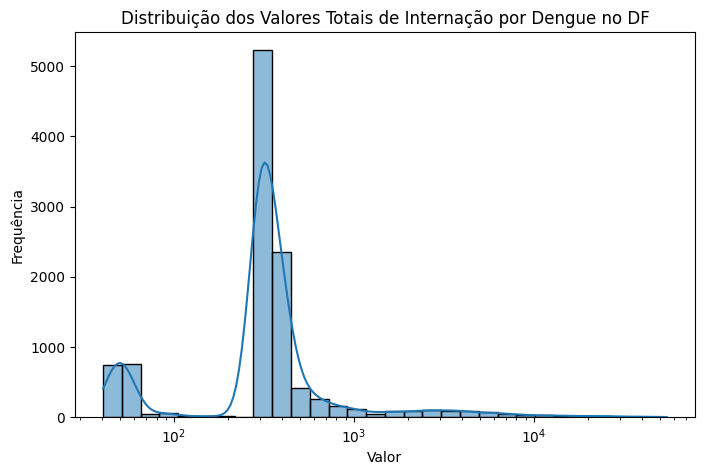

In [183]:
plt.figure(figsize=(8, 5))
sns.histplot(dengue_df['vl_total'], bins=30, kde=True, log_scale=(True, False))
plt.title("Distribuição dos Valores Totais de Internação por Dengue no DF")
plt.xlabel("Valor")
plt.ylabel("Frequência")
plt.show()